In [10]:
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import torch
import warnings
from typing import Dict, Any
from torch.utils.data import Dataset
from transformers import (
    pipeline,
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    TrainingArguments, 
    Trainer, 
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report
)

In [3]:
df = pd.read_csv('../data/cleaned_data.csv')

#### Data Preprocessing

Text(0.5, 1.0, 'Review Length Distribution')

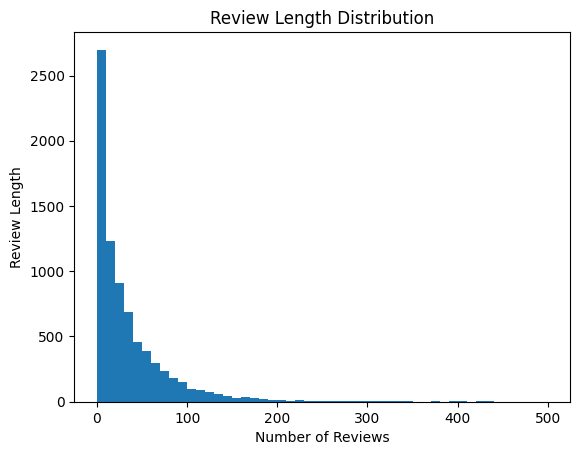

In [4]:
df['reviewText'].str.split().str.len().plot(kind='hist', bins=50, range=(0, 500))
plt.xlabel('Number of Reviews')
plt.ylabel('Review Length')
plt.title('Review Length Distribution')

In [5]:
# Check the maximum word count
max_word_count = df['reviewText'].str.split().str.len().max()
print(f"Maximum word count: {max_word_count}")

# Check distribution at higher thresholds
for threshold in [50, 100, 500, 1000, 2000, 3000]:
    count = (df['reviewText'].str.split().str.len() > threshold).sum()
    print(f"Reviews with more than {threshold} words: {count}")

Maximum word count: 3695
Reviews with more than 50 words: 1825
Reviews with more than 100 words: 613
Reviews with more than 500 words: 6
Reviews with more than 1000 words: 1
Reviews with more than 2000 words: 1
Reviews with more than 3000 words: 1


In [6]:
# Remove reviews with More than 100 words
# Set word count threshold
threshold = 100  

# Original size before filtering
original_size = len(df)

# Create a boolean mask for reviews below the threshold
mask = df['reviewText'].str.split().str.len() <= threshold

# Apply the mask to filter the DataFrame
df = df[mask]

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Check the new size
new_size = len(df)

print(f"Original data size: {original_size}")
print(f"New data size: {new_size}")
print(f"Total of {original_size - new_size} reviews were deleted")

Original data size: 7857
New data size: 7244
Total of 613 reviews were deleted


In [7]:
# Regex cleaning
def clean_text(text):
    """
    Comprehensive text cleaning function that applies multiple preprocessing steps.
    Args:
        text (str): Input text to be cleaned
    Returns:
        str: Cleaned text with punctuation, URLs, hashtags, usernames removed
    """
    # Compile regex patterns once for better performance
    patterns = [
        (r'http\S+', ''),           # Remove URLs more comprehensively
        (r'#\w+', ''),               # Remove hashtags
        (r'@\w+', ''),               # Remove usernames
        (r'[^\w\s]', ''),            # Remove punctuation
        (r'\s+', ' '),               # Replace multiple whitespaces with single space
        (r'\s\.?\s', ' ')            # Remove single characters between spaces
    ]
    
    # Apply all patterns in sequence
    for pattern, repl in patterns:
        text = re.sub(pattern, repl, text)
    
    return text.strip().lower()

In [8]:
# Apply the function to the filtered data
df['reviewText'] = df['reviewText'].apply(lambda x: clean_text(x))

#### Label Data

In [12]:
# Create a Label column
# Load a sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="tabularisai/robust-sentiment-analysis")

# Apply the pipeline to the reviewText column
df['label'] = df['reviewText'].apply(lambda x: sentiment_pipeline(x)[0]["label"])

df.head()

Device set to use cpu


,Unnamed: 0,index,authorName,googleMapsPlaceId,placeAddress,placeName,placeUrl,provider,reviewDate,reviewRating,...,reviewImages/4,reviewImages/5,reviewImages/6,reviewImages/7,reviewImages/8,reviewImages/9,reviewImages/10,reviewImages/11,reviewImages/12,label
0,0,1,Lindsey L,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2022-02-21,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Positive
1,1,2,Mara R,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2024-12-19,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Positive
2,2,3,Yvette Y,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2024-10-13,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Negative
3,3,4,Hugh M,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2024-07-22,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive
4,4,5,Erin L,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2024-04-11,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Positive


In [13]:
# Delete the Unnamed column
df = df.loc[:, ~df.columns.str.match('Unnamed')]

Text(0.5, 1.0, 'Sentiment Distribution')

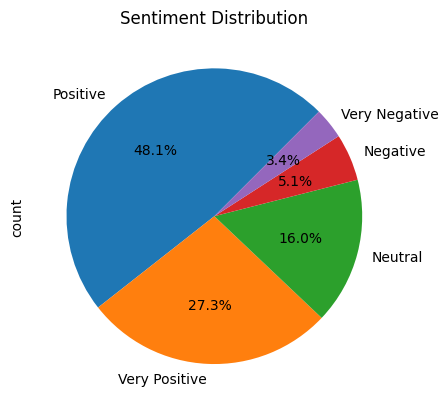

In [14]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=45)
plt.title('Sentiment Distribution')

#### Convert text labels to numbers

In [15]:
label_mapping = {"Very Positive": 1, "Positive": 1, "Neutral": -1, "Very Negative": 0, "Negative": 0}
df["sentiment"] = df["label"].map(label_mapping)

Text(0, 0.5, 'Count')

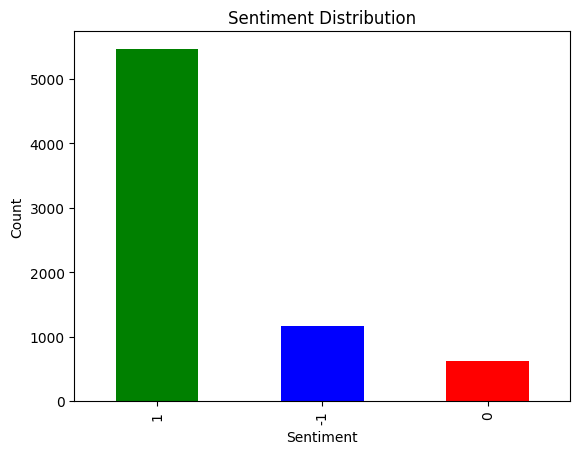

In [16]:
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

#### Split Data

In [17]:
# Split the data into training, validation, and testing sets
train_text, temp_text, train_sentiment, temp_sentiment = train_test_split(
    df["reviewText"].tolist(), df["sentiment"].tolist(), test_size=0.2, random_state=42
)

val_text, test_text, val_sentiment, test_sentiment = train_test_split(
    temp_text, temp_sentiment, test_size=0.5, random_state=42
)

##### Tokenize the data using DistilBERT tokenizer -> Tokenization

In [18]:
model_checkpoint = "distilbert-base-uncased"
num_labels = 3
output_dir = 'models/semtiment_model'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**'AutoModelForSequenceClassification'**
- **Library:** Framework-agnostic (works with both PyTorch and TensorFlow).
- **Purpose:** This is a higher-level, task-specific class designed for sequence classification tasks (e.g., sentiment analysis, text classification). It automatically loads a pretrained model (like DistilBERT, BERT, etc.) with a classification head on top, tailored for predicting labels.
- **Output:** It returns logits (raw prediction scores) for each class, which can be passed through a softmax function to get probabilities. It’s ready to use for classification tasks out of the box.
- **Use Case:** Use this when you want a prebuilt model for sequence classification without needing to manually add a classification head. It’s ideal for fine-tuning on labeled datasets.

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#### Create a dataset class 

In [ ]:
def tokenize_texts(texts):
    """Tokenizes a list of texts using the pretrained tokenizer."""
    return tokenizer(texts, truncation=True, padding=True, return_tensors="pt")  # returns BatchEncoding object

class SentimentDataset(Dataset):
    """
Custom PyTorch Dataset for sentiment classification.
Args:
    encodings (Dict): Tokenized input encodings
    labels (List): Corresponding sentiment labels
"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}


    def __len__(self):
        return len(self.labels)

# Tokenize datasets
train_dataset = SentimentDataset(tokenize_texts(train_text), train_sentiment)
val_dataset = SentimentDataset(tokenize_texts(val_text), val_sentiment)
test_dataset = SentimentDataset(tokenize_texts(test_text), test_sentiment)

#### Train the Model

In [ ]:
def compute_metrics(pred):
    """
    Compute evaluation metrics for the model.
    Args:
        pred: Prediction results from Trainer
    Returns:
        Dict of evaluation metrics
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Compute accuracy
    accuracy = accuracy_score(labels, preds)
    
    # Generate classification report
    class_report = classification_report(labels, preds, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'precision': class_report['macro avg']['precision'],
        'recall': class_report['macro avg']['recall'],
        'f1': class_report['macro avg']['f1-score']
    }

def train(
    train_dataset: Dataset, 
    val_dataset: Dataset,
    batch_size: int = 16,
    num_train_epochs: int = 3
):
    """
    Train the sentiment analysis model.
    Args:
        train_dataset (Dataset): Training dataset
        val_dataset (Dataset): Validation dataset
        batch_size (int): Training batch size
        num_train_epochs (int): Number of training epochs
    
    Returns:
        Trained model
    """
    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'{output_dir}/logs',
        logging_steps=10,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy'
    )
    
    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    # Train the model
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    logger.info("Starting model training...")
    trainer.train()
    
    return model

In [20]:
def compute_metrics(pred) -> Dict[str, float]:
    """
    Compute comprehensive evaluation metrics for the model.
    
    Args:
        pred: Prediction results from Trainer
    
    Returns:
        Dictionary of evaluation metrics
    """
    # Suppress future warnings
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    # Extract labels and predictions
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Compute individual metrics
    try:
        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, average='macro')
        recall = recall_score(labels, preds, average='macro')
        f1 = f1_score(labels, preds, average='macro')
        
        # Generate detailed classification report
        class_report = classification_report(labels, preds, output_dict=True)
        
        # Log the metrics
        logging.info("Model Evaluation Metrics:")
        logging.info(f"Accuracy: {accuracy:.4f}")
        logging.info(f"Precision: {precision:.4f}")
        logging.info(f"Recall: {recall:.4f}")
        logging.info(f"F1 Score: {f1:.4f}")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'detailed_report': class_report
        }
    
    except Exception as e:
        logging.error(f"Error computing metrics: {e}")
        return {}

def train_model(
    train_dataset: Dataset, 
    val_dataset: Dataset, 
    model: Any,  # Allow flexibility in model type
    output_dir: str = f'{output_dir}/results',
    batch_size: int = 16, 
    num_train_epochs: int = 3,
    learning_rate: float = 2e-5
) -> Trainer:
    """
    Train the sentiment analysis model with comprehensive configuration.
    
    Args:
        train_dataset (Dataset): Training dataset
        val_dataset (Dataset): Validation dataset
        model (Any): Model to be trained
        output_dir (str): Directory to save model outputs
        batch_size (int): Training batch size
        num_train_epochs (int): Number of training epochs
        learning_rate (float): Learning rate for training
    
    Returns:
        Trained Trainer instance
    """
    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    logger = logging.getLogger(__name__)
    
    # Prepare training arguments with enhanced configurability
    training_args = TrainingArguments(
        output_dir=output_dir,
        
        # Epoch and learning configurations
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        
        # Batch size configurations
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        
        # Optimization parameters
        warmup_steps=500,
        weight_decay=0.01,
        
        # Logging configurations
        logging_dir=f'{output_dir}/logs',
        logging_steps=10,
        
        # Evaluation and saving strategies
        eval_strategy='epoch',  # Updated from deprecated 'evaluation_strategy'
        save_strategy='epoch',
        
        # Model selection criteria
        load_best_model_at_end=True,
        metric_for_best_model='f1',  # More robust metric than accuracy
        
        # Additional training optimizations
        fp16=torch.cuda.is_available(),  # Enable mixed precision if GPU available
        dataloader_num_workers=4,  # Parallel data loading
        
        # Prevent overwriting
        overwrite_output_dir=False
    )
    
    # Initialize Trainer with comprehensive configuration
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=3,  # Stop if no improvement for 3 epochs
                early_stopping_threshold=0.01  # Minimum improvement required
            )
        ]
    )
    
    # Log training start
    logger.info("Starting model training...")
    
    try:
        # Train the model
        train_result = trainer.train()
        
        # Additional logging of training results
        logger.info("Training completed successfully.")
        logger.info(f"Total training time: {train_result.metrics.get('train_runtime', 'N/A')}")
        
        # Save final model
        trainer.save_model()
        
        return trainer
    
    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise e

#### Model Evaluation

In [21]:
def evaluate(test_dataset: Dataset):
    """
    Evaluate the model on test dataset.
    Args:
        test_dataset (Dataset): Test dataset
    Returns:
        Dictionary of evaluation metrics
    """
    trainer = Trainer(
        model=model,
        compute_metrics=compute_metrics
    )
    
    # Evaluate the model
    eval_results = trainer.evaluate(test_dataset)
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    logger.info("Test Evaluation Results:")
    for metric, value in eval_results.items():
        logger.info(f"{metric}: {value}")
    
    return eval_results

#### Save & Load the Model for Future Use

In [22]:
def save_model(self):
    """Save the trained model and tokenizer."""
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(self.output_dir)
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    logger.info(f"Model saved to {output_dir}")

In [26]:
# Train the model
trained_model = train_model(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

2025-03-25 16:42:40,459 - INFO - Starting model training...


/workspaces/Rreview_Analyzer/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid u

: 

In [ ]:

# Evaluate the model
evaluate(test_dataset)

In [ ]:

# Save the model
save_model()

In [ ]:

# Train the model
trained_model = train_model(train_dataset, val_dataset, model, output_dir, batch_size=16, num_train_epochs=3)

# Evaluate the model
test_results = trained_model.predict(test_dataset)
test_metrics = compute_metrics(test_results)

# Save the model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [ ]:
import logging
import warnings
from typing import Dict, Any

import torch
from torch.utils.data import Dataset
from transformers import (
    TrainingArguments, 
    Trainer, 
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report
)

def compute_metrics(pred) -> Dict[str, float]:
    """
    Compute comprehensive evaluation metrics for the model.
    
    Args:
        pred: Prediction results from Trainer
    
    Returns:
        Dictionary of evaluation metrics
    """
    # Suppress future warnings
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    # Extract labels and predictions
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Compute individual metrics
    try:
        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, average='macro')
        recall = recall_score(labels, preds, average='macro')
        f1 = f1_score(labels, preds, average='macro')
        
        # Generate detailed classification report
        class_report = classification_report(labels, preds, output_dict=True)
        
        # Log the metrics
        logging.info("Model Evaluation Metrics:")
        logging.info(f"Accuracy: {accuracy:.4f}")
        logging.info(f"Precision: {precision:.4f}")
        logging.info(f"Recall: {recall:.4f}")
        logging.info(f"F1 Score: {f1:.4f}")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'detailed_report': class_report
        }
    
    except Exception as e:
        logging.error(f"Error computing metrics: {e}")
        return {}

def train_model(
    train_dataset: Dataset, 
    val_dataset: Dataset, 
    model: Any,  # Allow flexibility in model type
    output_dir: str = './results',
    batch_size: int = 16, 
    num_train_epochs: int = 3,
    learning_rate: float = 2e-5
) -> Trainer:
    """
    Train the sentiment analysis model with comprehensive configuration.
    
    Args:
        train_dataset (Dataset): Training dataset
        val_dataset (Dataset): Validation dataset
        model (Any): Model to be trained
        output_dir (str): Directory to save model outputs
        batch_size (int): Training batch size
        num_train_epochs (int): Number of training epochs
        learning_rate (float): Learning rate for training
    
    Returns:
        Trained Trainer instance
    """
    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    logger = logging.getLogger(__name__)
    
    # Prepare training arguments with enhanced configurability
    training_args = TrainingArguments(
        output_dir=output_dir,
        
        # Epoch and learning configurations
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        
        # Batch size configurations
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        
        # Optimization parameters
        warmup_steps=500,
        weight_decay=0.01,
        
        # Logging configurations
        logging_dir=f'{output_dir}/logs',
        logging_steps=10,
        
        # Evaluation and saving strategies
        eval_strategy='epoch',  # Updated from deprecated 'evaluation_strategy'
        save_strategy='epoch',
        
        # Model selection criteria
        load_best_model_at_end=True,
        metric_for_best_model='f1',  # More robust metric than accuracy
        
        # Additional training optimizations
        fp16=torch.cuda.is_available(),  # Enable mixed precision if GPU available
        dataloader_num_workers=4,  # Parallel data loading
        
        # Prevent overwriting
        overwrite_output_dir=False
    )
    
    # Initialize Trainer with comprehensive configuration
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=3,  # Stop if no improvement for 3 epochs
                early_stopping_threshold=0.01  # Minimum improvement required
            )
        ]
    )
    
    # Log training start
    logger.info("Starting model training...")
    
    try:
        # Train the model
        train_result = trainer.train()
        
        # Additional logging of training results
        logger.info("Training completed successfully.")
        logger.info(f"Total training time: {train_result.metrics.get('train_runtime', 'N/A')}")
        
        # Save final model
        trainer.save_model()
        
        return trainer
    
    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise

def main():
    """
    Example usage of the training function.
    
    Note: Replace with actual dataset preparation
    """
    # Placeholder for dataset and model initialization
    # You would typically have:
    # 1. Prepared train_dataset
    # 2. Prepared val_dataset
    # 3. Initialized model
    
    try:
        # Example training call (commented out as placeholders)
        # trained_model = train_model(
        #     train_dataset=train_dataset, 
        #     val_dataset=val_dataset,
        #     model=your_model,
        #     output_dir='./sentiment_model_results'
        # )
        pass
    
    except Exception as e:
        logging.error(f"Training process failed: {e}")

if __name__ == '__main__':
    main()